In [1]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0 #Pet pixel (segmentation target)
    BACKGROUND = 1 #background pixel
    BORDER = 2 #border (ambiguous) region pixel

# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs


# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)


In [5]:

def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join(working_dir, cp_name))


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
    # end while
# end def


# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"



# SegNet ### https://arxiv.org/abs/1511.00561
# Model definition. We use a SegNet-Basic model with some minor tweaks.
# Our input images are 128x128.
class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y
class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 3
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownConv2(3, 64, kernel_size=kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size=kernel_size)
        self.dc3 = DownConv3(128, 256, kernel_size=kernel_size)
        self.dc4 = DownConv3(256, 512, kernel_size=kernel_size)
        # self.dc5 = DownConv3(512, 512, kernel_size=kernel_size)
        
        # self.uc5 = UpConv3(512, 512, kernel_size=kernel_size)
        self.uc4 = UpConv3(512, 256, kernel_size=kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size=kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size=kernel_size)
        self.uc1 = UpConv2(64, 3, kernel_size=kernel_size)
        
    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # SegNet Encoder
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)
        # Our images are 128x128 in dimension. If we run 4 max pooling
        # operations, we are down to 128/16 = 8x8 activations. If we
        # do another down convolution, we'll be at 4x4 and at that point
        # in time, we may lose too much spatial information as a result
        # of the MaxPooling operation, so we stop at 4 down conv
        # operations.
        # x, mp5_indices, shape5 = self.dc5(x)

        # SegNet Decoder
        # x = self.uc5(x, mp5_indices, output_size=shape5)
        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)
        
        return x
    # end def
# end class

# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)
    # end if
    
    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
    
    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())
    # end def
# end class

    def test_custom_iou_loss():
        #               B, C, H, W
        x = torch.rand((2, 3, 2, 2), requires_grad=True)
        y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
        z = IoULoss(softmax=True)(x, y)
        return z
    # end def

# Train the model for a single epoch
def train_model(model, loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)
    # end if

    running_loss = 0.0
    running_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)
        
        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        # end if
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
        running_samples += targets.size(0)
        running_loss += loss.item()
    # end for

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))
# end def

#### helpers for validation
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()
    
def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)
    
    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()
    
    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")
    
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if
    
    if show_plot is False:
        close_figures()
    else:
        plt.show()
    # end if
# end def

def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    
    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []
    
    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)
        
        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())
        
        del inputs
        del targets
        del predictions
    # end for
    
    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)
    
    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")


# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    ###
    dur = []
    training_start_time = time.time()
    ####
    for i in range(epoch_i, epoch_j):
        t0 = time.time()
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))
        # end with

        if scheduler is not None:
            scheduler.step()
        # end if
        ###
        
        dur.append(time.time() - t0)
        print()
        ###
        print("epoch:{:d}, training time:{:.4f}s".format(epoch,dur[-1]))
    # end for
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
# end def

CUDA: True
/kaggle/working/OxfordPets/train 	 Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: /kaggle/working/OxfordPets/train 
 /kaggle/working/OxfordPets/test 	 Dataset OxfordIIITPet
    Number of datapoints: 3669
    Root location: /kaggle/working/OxfordPets/test
train inputs:torch.Size([64, 3, 128, 128]), train targets:torch.Size([64, 1, 128, 128])
test inputs: torch.Size([21, 3, 128, 128]), test targets:torch.Size([21, 1, 128, 128])
model tensor shape:	torch.Size([64, 3, 128, 128])
Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.9140
Epoch: 01, Accuracy[Pixel: 0.5416, IoU: 0.5438, Custom IoU: 0.2633]

epoch:1, training time:59.3758s
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7808
Epoch: 02, Accuracy[Pixel: 0.7103, IoU: 0.4526, Custom IoU: 0.3240]


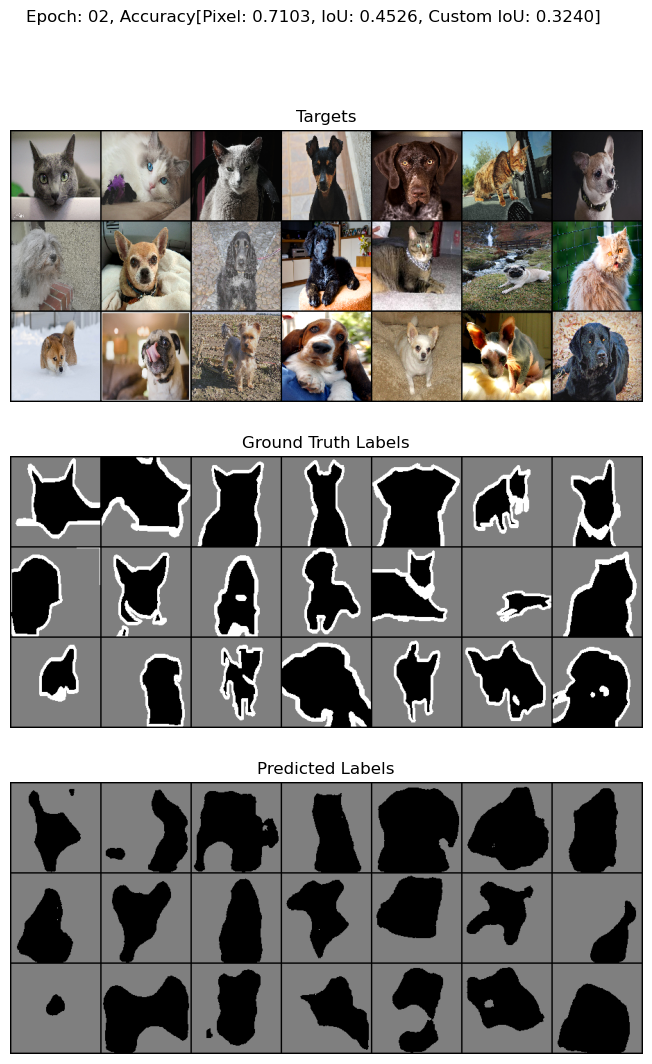


epoch:2, training time:59.0848s
Training finished, took 118.46s
The Model has 15.27M parameters


In [6]:
# if __name__ == "__main__":
# Set the working (writable) directory.
# print("running ", os.path.abspath(__file__))
print(f"CUDA: {torch.cuda.is_available()}")
#working_dir = "./"
working_dir = "/kaggle/working/"

# pets_data = torchvision.datasets.OxfordIIITPet(working_dir)
# data_loader = torch.utils.data.DataLoader(pets_data,
#             batch_size=4,
#             shuffle=True,
#             num_workers=1)#args.nThreads)
# print(data_loader)

# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

print(pets_path_train,'\t', pets_train_orig,'\n',pets_path_test,'\t', pets_test_orig)

# (train_pets_input, train_pets_target) = pets_train_orig[10]
# train_pets_input.show()
# train_pets_target.show()
# Validation: Check if CUDA is available

# Spot check a segmentation mask image after post-processing it
# via trimap2f().
# print(train_pets_input,'\n',train_pets_target)
# t2img(trimap2f(train_pets_target)).show()
# train_pets_target.show()



transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
print(f"train inputs:{train_pets_inputs.shape}, train targets:{train_pets_targets.shape}")
print(f"test inputs: {test_pets_inputs.shape}, test targets:{test_pets_targets.shape}")

# Let's inspect some of the images.
# pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
# t2img(pets_input_grid).show()
# pets_input_grid = torchvision.utils.make_grid(test_pets_inputs, nrow=7)
# t2img(pets_input_grid).show()
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
# pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
# t2img(pets_targets_grid).show()
#                  N  C  H
# The printed row is the W dimension.
# print(train_pets_targets[3][0][4])
# print(train_pets_targets[63][0][127]) #### maximum index each dimension [index in batx] [???] [index in pixel resolution]

# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
m = ImageSegmentation(kernel_size=3)
m.eval()
to_device(m)
print(f"model tensor shape:\t{m(to_device(train_pets_inputs)).shape}")

# Check if our helper functions work as expected and if the image
# is generated as expected.
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
# print_test_dataset_masks(m, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)
# Optimizer and Learning Rate Scheduler.
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

# Train our model for 20 epochs, and record the following:
#
# 1. Training Loss
# 2. Test accuracy metrics for a single batch (21 images) of test images. The following
#    metrics are computed:
#   2.1. Pixel Accuracy
#   2.2. IoU Accuracy (weighted)
#   2.3. Custom IoU Accuracy
#
# We also plot the following for each of the 21 images in the validation batch:
# 1. Input image
# 2. Ground truth segmentation mask
# 3. Predicted segmentation mask
#
# so that we can visually inspect the model's progres and determine how well the model
# is doing qualitatively. Note that the validation metrics on the set of 21 images in
# the validation set is displayed inline in the notebook only for the last training
# epoch.
#
# save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
first_epoch=1
last_epoch=25
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (first_epoch, last_epoch+1), optimizer, scheduler, save_path)
# Save the model's checkpoint.
save_model_checkpoint(m, f"pets_segnet_CrossEntropyLoss_LRSchedule_epoch_{first_epoch}_{last_epoch}.pth")
print_model_parameters(m)

In [ ]:
# # save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
# train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (2,3), optimizer, scheduler, save_path)
# # Save the model's checkpoint.
# save_model_checkpoint(m, f"pets_segnet_basic_CrossEntropyLoss_LRSchedule_2_epochs.pth")
# print_model_parameters(m)